# Importing Libraries

In [ ]:
!pip install transformers
!pip install pytorch-lightning
!pip install torchmetrics

from sklearn.datasets import fetch_20newsgroups

import torch
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from transformers import AdamW
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
import torchmetrics

# Downloading the Dataset

In [2]:
# Loading the 20 Newsgroups dataset
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

# Data Exploration

In [3]:
# Getting the class names
class_names = newsgroups_train.target_names

# Printing the class names
print(class_names)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [4]:
# Example: Printing the first document and its corresponding class name
first_document = newsgroups_train.data[1]
first_target = newsgroups_train.target[1]
first_class_name = class_names[first_target]

print(f"First document:\n{first_document}")
print(f"Class name: {first_class_name}")


First document:
From: guykuo@carson.u.washington.edu (Guy Kuo)
Subject: SI Clock Poll - Final Call
Summary: Final call for SI clock reports
Keywords: SI,acceleration,clock,upgrade
Article-I.D.: shelley.1qvfo9INNc3s
Organization: University of Washington
Lines: 11
NNTP-Posting-Host: carson.u.washington.edu

A fair number of brave souls who upgraded their SI clock oscillator have
shared their experiences for this poll. Please send a brief message detailing
your experiences with the procedure. Top speed attained, CPU rated speed,
add on cards and adapters, heat sinks, hour of usage per day, floppy disk
functionality with 800 and 1.4 m floppies are especially requested.

I will be summarizing in the next two days, so please add to the network
knowledge base if you have done the clock upgrade and haven't answered this
poll. Thanks.

Guy Kuo <guykuo@u.washington.edu>

Class name: comp.sys.mac.hardware


In [5]:
#Combining train and test datasets for a complete distribution
all_targets = list(newsgroups_train.target) + list(newsgroups_test.target)

# Getting the class names
class_names = newsgroups_train.target_names

# Counting the number of documents in each class
from collections import Counter
class_distribution = Counter(all_targets)

# Print class distribution for verification
print(class_distribution)

Counter({10: 999, 15: 997, 8: 996, 9: 994, 11: 991, 7: 990, 13: 990, 5: 988, 14: 987, 2: 985, 12: 984, 3: 982, 6: 975, 1: 973, 4: 963, 17: 940, 16: 910, 0: 799, 18: 775, 19: 628})


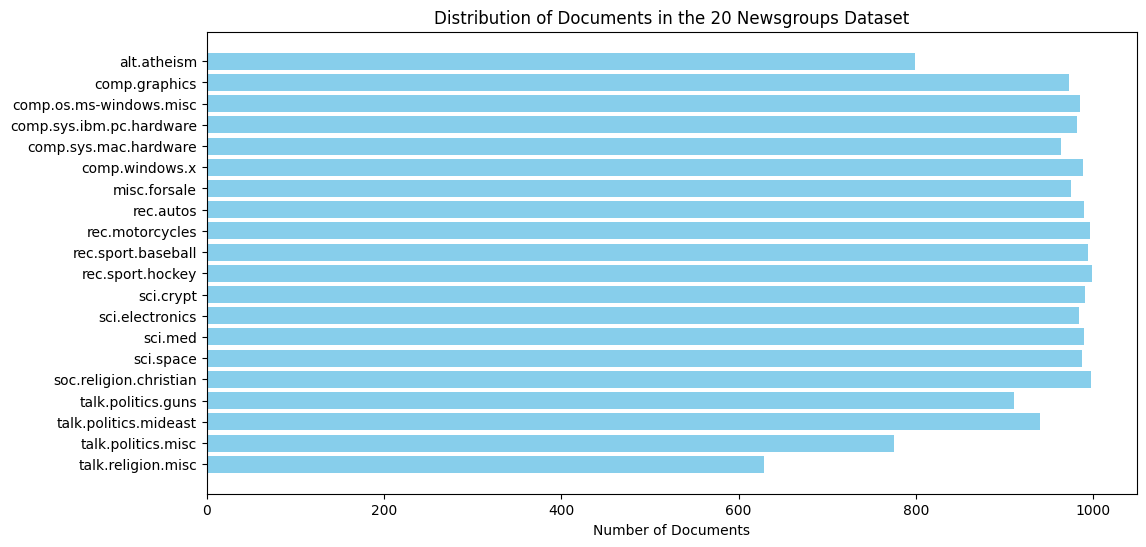

In [6]:
# Creating lists of class names and their respective counts
class_labels = [class_names[i] for i in range(len(class_names))]
class_counts = [class_distribution[i] for i in range(len(class_names))]

import matplotlib.pyplot as plt
# Plotting the class distribution
plt.figure(figsize=(12, 6))
plt.barh(class_labels, class_counts, color='skyblue')
plt.xlabel('Number of Documents')
plt.title('Distribution of Documents in the 20 Newsgroups Dataset')
plt.gca().invert_yaxis()
plt.show()


# Preprocessing

In [7]:
# importing BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [8]:
# Custom Dataset
class NewsGroupsDataset(Dataset):
    def __init__(self, texts, targets):
        self.texts = texts
        self.targets = targets

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = tokenizer.encode_plus(
            self.texts[idx],
            add_special_tokens=True,
            max_length=512,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(self.targets[idx])
        return item

In [9]:
class NewsGroupsDataModule(pl.LightningDataModule):
    def __init__(self, train_texts, train_labels, val_texts, val_labels, test_texts, test_labels, batch_size=8):
        super().__init__()
        self.train_texts = train_texts
        self.train_labels = train_labels
        self.val_texts = val_texts
        self.val_labels = val_labels
        self.test_texts = test_texts
        self.test_labels = test_labels
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = NewsGroupsDataset(self.train_texts, self.train_labels)
        self.val_dataset = NewsGroupsDataset(self.val_texts, self.val_labels)
        self.test_dataset = NewsGroupsDataset(self.test_texts, self.test_labels)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True,num_workers=8)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size,num_workers=8)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size,num_workers=8)


# The Neural Network

In [10]:
# Defining the neural network
class NewsGroupsModel(pl.LightningModule):
    def __init__(self, n_classes):
        super().__init__()
        self.model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=n_classes)
        self.criterion = torch.nn.CrossEntropyLoss()
        self.train_f1 = torchmetrics.F1Score(num_classes=n_classes, average='weighted',task='multiclass')
        self.val_f1 = torchmetrics.F1Score(num_classes=n_classes, average='weighted',task='multiclass')
        self.test_f1 = torchmetrics.F1Score(num_classes=n_classes, average='weighted',task='multiclass')
        self.train_acc = torchmetrics.Accuracy(num_classes=n_classes, average='weighted',task='multiclass')
        self.val_acc = torchmetrics.Accuracy(num_classes=n_classes, average='weighted',task='multiclass')
        self.test_acc = torchmetrics.Accuracy(num_classes=n_classes, average='weighted',task='multiclass')

    def forward(self, input_ids, attention_mask, labels=None):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        return output

    def training_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        outputs = self(input_ids, attention_mask, labels)
        loss = outputs.loss
        preds = torch.argmax(outputs.logits, dim=1)
        f1 = self.train_f1(preds, labels)
        acc = self.train_acc(preds, labels)
        self.log('train_loss', loss)
        self.log('train_f1', f1, prog_bar=True, logger=True)
        self.log('train_acc', acc, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        outputs = self(input_ids, attention_mask, labels)
        loss = outputs.loss
        preds = torch.argmax(outputs.logits, dim=1)
        f1 = self.val_f1(preds, labels)
        acc = self.val_acc(preds, labels)
        self.log('val_loss', loss, prog_bar=True, logger=True)
        self.log('val_f1', f1, prog_bar=True, logger=True)
        self.log('val_acc', acc, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        outputs = self(input_ids, attention_mask, labels)
        loss = outputs.loss
        preds = torch.argmax(outputs.logits, dim=1)
        f1 = self.test_f1(preds, labels)
        acc = self.test_acc(preds, labels)
        self.log('test_loss', loss, prog_bar=True, logger=True)
        self.log('test_f1', f1, prog_bar=True, logger=True)
        self.log('test_acc', acc, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=2e-5)
        return optimizer


# Splitting into Train, Test, and Validation Sets

In [11]:
# Splitting the dataset into training, validation, and test sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    newsgroups_train.data, newsgroups_train.target, test_size=0.2, random_state=42)

test_texts, test_labels = newsgroups_test.data, newsgroups_test.target

In [12]:
# Initializing the data module
data_module = NewsGroupsDataModule(train_texts, train_labels, val_texts, val_labels, test_texts, test_labels, batch_size=8)


# Training the Model

In [13]:
# Initializing the model
model = NewsGroupsModel(n_classes=len(newsgroups_train.target_names))

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# Initializing the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='my_model_checkpoints',
    filename='bert-newsgroups-{epoch:02d}-{val_acc:.2f}',
    save_top_k=1,
    mode='max',
)
csv_logger = CSVLogger("logs", name="my_model")

In [17]:
# Initializing the trainer
trainer = pl.Trainer(max_epochs=3, callbacks=[checkpoint_callback],logger=csv_logger)

# Training the model
trainer.fit(model, data_module)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementat

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


# Training and Validation Curves

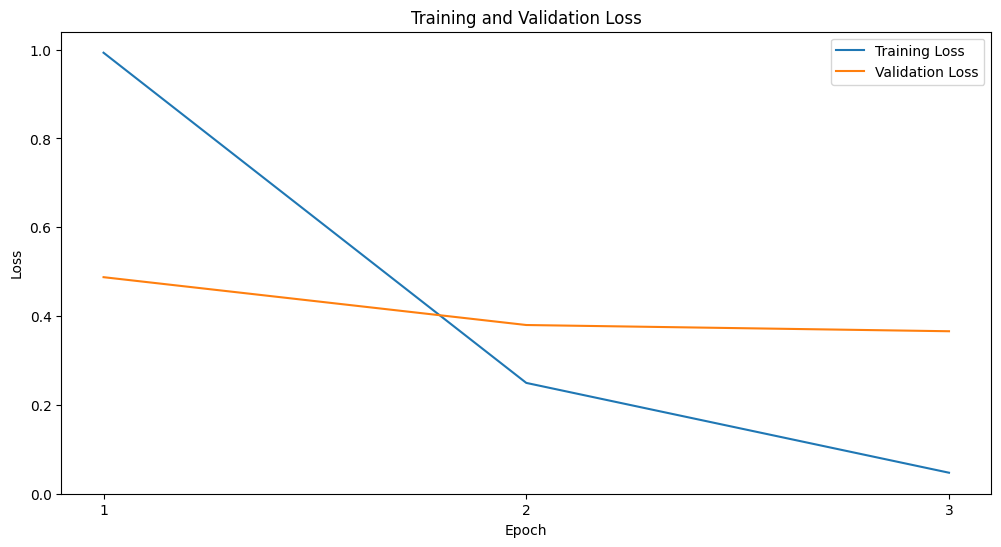

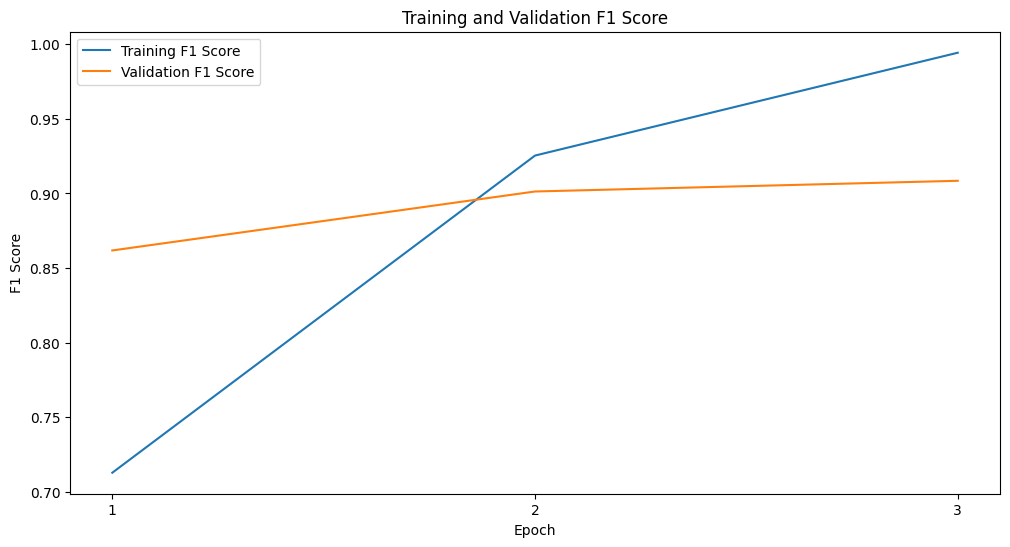

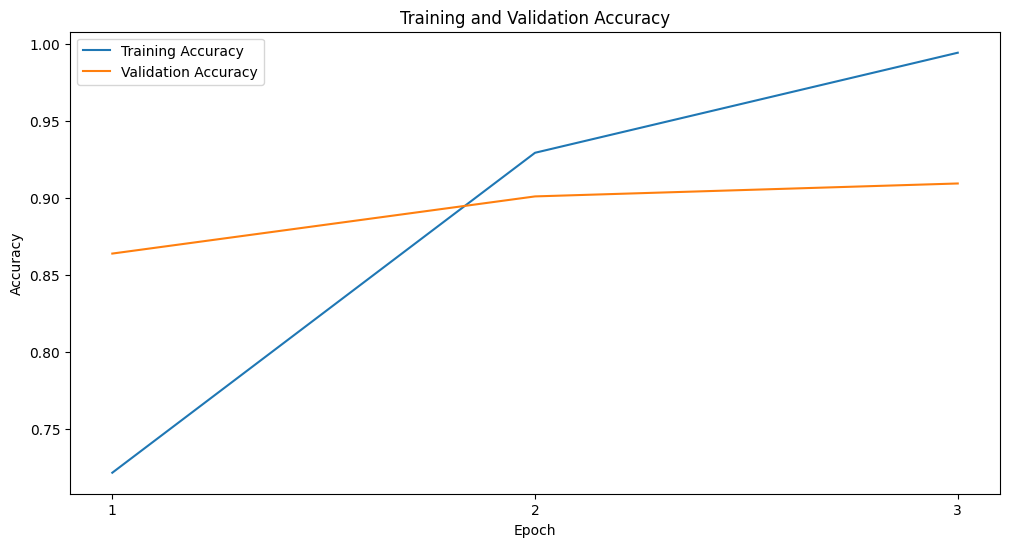

In [26]:
import os
import pandas as pd

# Defining the path to the CSV log file
csv_log_path = '/content/logs/my_model/version_0/metrics.csv'

# Loading the logs
metrics = pd.read_csv(csv_log_path)

# Ensuring the epoch column is treated as integers
metrics['epoch'] = metrics['epoch'].astype(int)

# Grouping by epoch and calculate mean values for each epoch
grouped_metrics = metrics.groupby('epoch').mean().reset_index()

# Adjusting epoch numbering to start from 1
grouped_metrics['epoch'] += 1

# Defining the epochs for x-ticks
epochs = [1, 2, 3]

# Plotting training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(grouped_metrics['epoch'], grouped_metrics['train_loss'], label='Training Loss')
if 'val_loss' in grouped_metrics.columns:
    plt.plot(grouped_metrics['epoch'], grouped_metrics['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.xticks(epochs)
plt.legend()
plt.show()

# Plotting training and validation F1 score
plt.figure(figsize=(12, 6))
plt.plot(grouped_metrics['epoch'], grouped_metrics['train_f1'], label='Training F1 Score')
if 'val_f1' in grouped_metrics.columns:
    plt.plot(grouped_metrics['epoch'], grouped_metrics['val_f1'], label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Training and Validation F1 Score')
plt.xticks(epochs)
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(grouped_metrics['epoch'], grouped_metrics['train_acc'], label='Training Accuracy')
if 'val_acc' in grouped_metrics.columns:
    plt.plot(grouped_metrics['epoch'], grouped_metrics['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.xticks(epochs)
plt.legend()
plt.show()


# Evaluating the Model

In [21]:
# Evaluating the model on the test set
trainer.test(model, datamodule=data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8454594016075134     │
│          test_f1          │     0.842987060546875     │
│         test_loss         │    0.5875590443611145     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5875590443611145,
  'test_f1': 0.842987060546875,
  'test_acc': 0.8454594016075134}]